In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from glob import glob
from datetime import datetime, date, time, timedelta
from collections import defaultdict

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
snm_df=pd.read_csv('../data/StationNamesMap.csv') #, index_col='TurnstileStationName')
snm_df.head()

,TurnstileStationName,StationLocationName
0,1 AV,1st Av
1,103 ST,103rd St
2,103 ST-CORONA,103rd St
3,104 ST,104th St-102nd St
4,110 ST,110th St


In [4]:
lat_lon_df = pd.read_csv('station_lat_lon.csv')
lat_lon_df.head()

,Station_Name,Station_Latitude,Station_Longitude
0,Ditmars Blvd,40.775036,-73.912034
1,Astoria Blvd-Hoyt Av,40.770258,-73.917843
2,30 Av-Grand Av,40.766779,-73.921479
3,Broadway,40.761820,-73.925508
4,36 Av-Washington Av,40.756804,-73.929575


In [5]:
# Borrowed from Metis class, generates integers.
def generate_numbers():
    """
    An infinite number generator ... stolen from Metis
    """
    x = 0
    while True:
        x += 1
        yield x # instead of return, I use yield, which makes this into a generator!

id_gen = generate_numbers()

In [6]:
# Set the number of rows to display when viewing dataframes / head / tail
pd.set_option("display.max_rows", 101)

In [7]:
# A function for viewing problematic rows. Show preceeding and following rows.
def sample(frame, index):
    """Returns three lines from a dataframe centered around the index parameter"""
    return frame.loc[index-1:index+1]

In [8]:
def am_pm(datetime_series):
    """Creates a Pandas Series object with the same index as the input index and values of
    AM or PM depeneding on the supplied timestamp."""
    s = pd.Series(index=datetime_series.index)
    for index, value in datetime_series.items():
        entry_time = datetime_series[index].time()
        if  entry_time > time(12,0,0) or entry_time == time(0,0,0):
            s[index] = 'PM'
        else:
            s[index] = 'AM'
    return s

In [9]:
def simplify_id(series):
    """Takes a series and changes the values to simple integers. This is to speed up comparisons"""
    s = pd.Series(index=series.index)
    id_set = set(series)
    d = {val : next(id_gen) for val in id_set}
    for index, value in series.iteritems():
        s[index] = d[value]
    return s

In [10]:
# Read data files
list_of_data_files = glob('../data/*.txt')
# list_of_data_files = glob('../data/turnstile_190330.txt')
list_of_data_files

# Read data files into pandas dataframes
list_of_dataframes = [pd.read_csv(file) for file in list_of_data_files]
df = pd.concat(list_of_dataframes)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573


In [11]:
df = df.merge(snm_df, how='inner', left_on='STATION', right_on='TurnstileStationName')
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TurnstileStationName,StationLocationName
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,59 ST,59th St
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,59 ST,59th St
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,59 ST,59th St
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,59 ST,59th St
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,59 ST,59th St


In [12]:
df['STATION'] = df['StationLocationName']

In [13]:
df = df.merge(lat_lon_df, how='inner', left_on='STATION', right_on='Station_Name')
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TurnstileStationName,StationLocationName,Station_Name,Station_Latitude,Station_Longitude
0,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,59 ST,59th St,59th St,40.641362,-74.017881
1,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,59 ST,59th St,59th St,40.641362,-74.017881
2,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,59 ST,59th St,59th St,40.641362,-74.017881
3,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,59 ST,59th St,59th St,40.641362,-74.017881
4,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,59 ST,59th St,59th St,40.641362,-74.017881


In [14]:
df.drop(['TurnstileStationName', 'StationLocationName', 'Station_Name'], axis=1, inplace=True)

In [15]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Station_Latitude,Station_Longitude
0,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,40.641362,-74.017881
1,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,40.641362,-74.017881
2,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,40.641362,-74.017881
3,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,40.641362,-74.017881
4,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,40.641362,-74.017881


In [16]:
df.to_csv('./notrack/agg_station_data.csv', index=False)

In [17]:
# Clean up strange spaces in column names
df.columns = df.columns.str.strip()
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'Station_Latitude', 'Station_Longitude'],
      dtype='object')

In [18]:
# Create a tuples of columns 'C/A', 'UNIT', 'SCP', 'STATION'
df['ID'] = pd.Series(zip(df['C/A'], df['UNIT'], df['SCP'], df['STATION']))

In [19]:
# Replace IDs created above with itengers because processing tuples is really slow
# df['NEW_ID'] = simplify_id(df['ID'])

In [20]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID
0,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
1,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
2,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
3,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
4,A002,R051,02-00-00,59th St,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2856838 entries, 0 to 2856837
Data columns (total 14 columns):
C/A                  object
UNIT                 object
SCP                  object
STATION              object
LINENAME             object
DIVISION             object
DATE                 object
TIME                 object
DESC                 object
ENTRIES              int64
EXITS                int64
Station_Latitude     float64
Station_Longitude    float64
ID                   object
dtypes: float64(2), int64(2), object(10)
memory usage: 326.9+ MB


In [22]:
# Filter out df['DESC'] == 'RECOVR AUD'. These entries create large jumps in entry counts
df = df[df['DESC'] != 'RECOVR AUD']

In [23]:
# Add a weekday column
df['DATE_TIME'] = df['DATE'] + ' ' + df['TIME']
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['WEEKDAY'] = df['DATE_TIME'].dt.day_name()

In [24]:
# Drop unneeded columns
df.drop(['LINENAME', 'DIVISION', 'DESC', 'C/A', 'UNIT', 'SCP', 'TIME'], inplace=True, axis=1)

In [25]:
# Limit to one station for simplicity
# df = df[df['STATION'] == '59 ST']
df.head()

,STATION,DATE,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID,DATE_TIME,WEEKDAY
0,59th St,03/23/2019,6989774,2370411,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 00:00:00,Saturday
1,59th St,03/23/2019,6989795,2370413,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 04:00:00,Saturday
2,59th St,03/23/2019,6989813,2370436,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 08:00:00,Saturday
3,59th St,03/23/2019,6989924,2370512,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 12:00:00,Saturday
4,59th St,03/23/2019,6990200,2370573,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 16:00:00,Saturday


In [26]:
# cache the number of rows for a future sanity check
rows_in_orig = df.shape[0]

In [27]:
# Create a disctiondary of dataframes for each turnstile id for entry count processing
# dict_of_ids = {id : df[df['NEW_ID'] == id] for id in df['NEW_ID'].unique()}
dict_of_ids = {id : df[df['ID'] == id] for id in df['ID'].unique()}

In [28]:
# Sanity check to be sure things worked
dict_of_ids[8210.0].head()

KeyError: 8210.0

In [29]:
# Create Entry counts based on subtracting a an entry count from the entry count in the next row.
for key, frame in dict_of_ids.items():
    dict_of_ids[key]['ENTRY_COUNT'] = abs(frame['ENTRIES'] - frame['ENTRIES'].shift(1)) + \
                                        abs(frame['EXITS'] - frame['EXITS'].shift(1))
    dict_of_ids[key]['ENTRY_COUNT'].fillna(0, inplace=True)

/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [30]:
# Recombine the dataframe from the dictionary of dataframes, now with entry counts
df = pd.concat(dict_of_ids.values())

In [31]:
# Check the number of rows to be sure we didn't gain or lose anything
assert(df.shape[0] == rows_in_orig)

In [32]:
df.shape

(2843925, 10)

In [33]:
# Filter out counts larger than 300 because they are almost always turnstile resets.
df = df[df['ENTRY_COUNT'] < 3000]

In [34]:
# Create a DATE column from the DATE_TIME timestamp.
df['DATE'] = df['DATE_TIME'].dt.date

In [35]:
df.head()

,STATION,DATE,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID,DATE_TIME,WEEKDAY,ENTRY_COUNT
0,59th St,2019-03-23,6989774,2370411,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 00:00:00,Saturday,0.0
1,59th St,2019-03-23,6989795,2370413,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 04:00:00,Saturday,23.0
2,59th St,2019-03-23,6989813,2370436,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 08:00:00,Saturday,41.0
3,59th St,2019-03-23,6989924,2370512,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 12:00:00,Saturday,187.0
4,59th St,2019-03-23,6990200,2370573,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-03-23 16:00:00,Saturday,337.0


In [36]:
# Sum up entry counts by date and weekday. This is a little redundant, but the WEEKDAY
# column is needed for later processing.
gp_date_weekday = df.groupby(['STATION', 'DATE', 'WEEKDAY'], as_index=False).sum()

In [37]:
gp_date_weekday.head()

,STATION,DATE,WEEKDAY,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ENTRY_COUNT
0,103rd St,2019-02-23,Saturday,1143097080,3370104475,4895.531040,-8875.374480,48085.0
1,103rd St,2019-02-24,Sunday,1371871398,4044246478,5874.637248,-10650.449376,44053.0
2,103rd St,2019-02-25,Monday,1375933523,3571298875,5997.025524,-10872.333738,83733.0
3,103rd St,2019-02-26,Tuesday,1372394119,4044605798,5874.637248,-10650.449376,87300.0
4,103rd St,2019-02-27,Wednesday,1372701220,4044821775,5874.637248,-10650.449376,85939.0


In [38]:
# Calculate the mean number of entries for each station.
daily_mean_by_station = gp_date_weekday.groupby('STATION', as_index=False).mean()

In [39]:
# Round off the mean values as they have a crazy number of decimal places.
daily_mean_by_station['ENTRY_COUNT'] = daily_mean_by_station['ENTRY_COUNT'].round(0)
# daily_mean_by_station.sort_values('ENTRY_COUNT', ascending=False, inplace=True)

In [40]:
# Create a new dataframe of the file largest stations by entry count
five_largest = daily_mean_by_station.nlargest(5, 'ENTRY_COUNT').sort_values('ENTRY_COUNT', ascending=False)
station = five_largest.STATION
entry_counts = five_largest.ENTRY_COUNT
five_largest.to_csv('five_largest_stations.csv')

In [41]:
# Create a reversed index so that stations display in descending order in the bar graph
new_index = list(reversed(station.index))

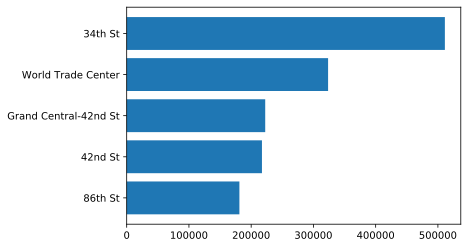

In [42]:
# Plot the bar chart of the top 5 stations
plt.barh(station[new_index], entry_counts[new_index]);

In [ ]:
# Create a series of the top ten stations
top_ten_stations = daily_mean_by_station.nlargest(10, 'ENTRY_COUNT').STATION
top_ten_stations

In [ ]:
top_ten_series = pd.Series(gp_top_ten_weekday.STATION.unique())[[2, 9, 7, 3, 1, 4, 0, 8, 6, 5]]

In [ ]:
top_ten_df = gp_date_weekday[gp_date_weekday['STATION'].isin(top_ten_stations)]
gp_top_ten_weekday = top_ten_df.groupby(['STATION', 'WEEKDAY'], as_index=False).mean()
# gp_top_ten_weekday.drop(['ENTRIES', 'NEW_ID'], axis=1, inplace=True)
gp_top_ten_weekday.drop(['ENTRIES'], axis=1, inplace=True)
gp_top_ten_weekday.head(2)
test = gp_top_ten_weekday.copy()
test.set_index('WEEKDAY', inplace=True)
wd_idx = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
gp_top_ten_weekday = test.copy()
legend_names = []
plt.figure(figsize = [12,5])
# for station in gp_top_ten_weekday.STATION.unique():
for station in top_ten_series:
    tmp_df = gp_top_ten_weekday[gp_top_ten_weekday['STATION'] == station]
    plt.plot(tmp_df['ENTRY_COUNT'][wd_idx])
    legend_names.append(station)
plt.ylabel('Passenger Count', fontsize = 14, weight = 'bold',color='black');
plt.title('Top Stations by Passenger Count', fontsize = 16, weight = 'bold',color='black')
plt.xlabel('Week Day', fontsize = 14, weight = 'bold',color='black')
# plt.legend(legend_names, shadow=True, loc = 0, fontsize=8);
plt.legend(top_ten_series, shadow=True, loc = 0, fontsize=8);
plt.savefig('top_stations.png')

In [ ]:
# gp_top_ten_weekday.head(20)

***

In [ ]:
tf = df[df['STATION'] == '34th St']
tf.shape

In [ ]:
tf.head(20)

In [ ]:
pickle.dump(df, open( "NYC_TS_DF.pickle", "wb" ) )

In [ ]:
gp_top_ten_weekday.STATION.unique()

In [ ]:
len(df.STATION.unique())

In [ ]:
df['ENTRY_COUNTS'] = count_entries(df)

In [ ]:
df['PCT_RANK'] = (df['ENTRY_COUNTS'].rank(pct=True) * 100).round(0)

In [ ]:
df.head()

In [ ]:
df[df['PCT_RANK'] == 99].shape

In [ ]:
# Filter out ENTRY_COUNTS greater than 3000 because these are usually counter resets
df = df[df['ENTRY_COUNTS'] < 3000]

In [ ]:
df[df['ENTRY_COUNTS'] < 0]

In [ ]:
print(df['ENTRY_COUNTS'].min(), df['ENTRY_COUNTS'].max()) 

In [ ]:
df['AM/PM'] = am_pm(df['DATE_TIME'])

In [ ]:
df.head()

In [ ]:
gp = df.groupby(['STATION', 'WEEKDAY', 'AM/PM'], as_index=False).sum()

In [ ]:
gp.head(100)

In [ ]:
gp_sorted = gp.sort_values(['ENTRY_COUNTS'], ascending=False)

In [ ]:
gp_sorted.nlargest(20, 'ENTRY_COUNTS')

In [ ]:
plt.hist(df.ENTRY_COUNTS[df.ENTRY_COUNTS < 2000])

In [ ]:
df = df[df['ENTRY_COUNTS'] < 4000]

In [ ]:
df.loc[36217:36221]

In [ ]:
df.ENTRY_COUNTS.median()

In [ ]:
df.ENTRY_COUNTS.mean()

In [ ]:
df.head()

In [ ]:
# Create a dict dataframes that contain the turnstile data for each station
dict_of_station_frames = {station : df[df.STATION == station] for station in df['STATION'].unique()}
len(dict_of_station_frames.keys())

In [ ]:
dict_of_station_frames['59 ST'].head()

In [ ]:
for name in dict_of_station_frames.keys():
    print(name + ':\n')
    print(dict_of_station_frames[name].describe())

In [ ]:
station_counts = defaultdict(int)
for name in dict_of_station_frames.keys():
    frame = dict_of_station_frames[name].copy()
    frame['ENTRY_COUNT'] = frame['ENTRIES'] - frame['ENTRIES'].shift(1)
    frame['ENTRY_COUNT'].fillna(0, inplace=True)
    dict_of_station_frames[name] = frame
    print(dict_of_station_frames[name].head(5))
    station_counts[name] = dict_of_station_frames[name]['ENTRY_COUNT'].sum()

In [ ]:
for key, value in station_counts.items():
    print(key, ':', value)

In [ ]:
for name in dict_of_station_frames.keys():
    

In [ ]:
df.head()

In [ ]:
# Filter data to daylight hours
times = ['12:00:00', '16:00:00', '20:00:00']
df = df[df['TIME'].isin(times)]

In [ ]:
gd = df.groupby(['STATION', 'WEEKDAY', 'TIME'], as_index=False).count()

In [ ]:
gd.head()